Earlier we trained a model to predict the ratings users would give to movies using a network with embeddings learned for each movie and user. Embeddings are powerful! But how do they actually work? 

Previously, I claimed that embeddings capture the 'meaning' of the objects they represent, and discover useful latent structure. Let's put that to the test!

# Looking up embeddings

Let's load a model we trained earlier so we can investigate the embedding weights that it learned.

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input/0-movielens-preprocessing' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
model_dir = '../input/x3-movielens-spiffy-model' if RUNNING_ON_KERNELS else '.'
model_path = os.path.join(model_dir, 'movie_svd_model_32.h5')
model = keras.models.load_model(model_path)

The embedding weights are part of the model's internals, so we'll have to do a bit of digging around to access them. We'll grab the layer responsible for embedding movies, and use the `get_weights()` method to get its learned weights.

In [ ]:
emb_layer = model.get_layer('movie_embedding')
(w,) = emb_layer.get_weights()
w.shape

(26744, 32)

Our weight matrix has 26,744 rows for that many movies. Each row is 32 numbers - the size of our movie embeddings.

Let's look at an example movie vector:

In [ ]:
w[0]

array([ 0.03214299, -0.51466346,  0.14373656, -0.78201973, -0.15541445,
        0.19800289, -0.22023553,  0.21002012, -0.18109643, -0.08783172,
        0.18439223, -0.19462438,  0.2783426 , -0.182823  ,  0.20774055,
       -0.37342644, -0.05344471,  0.26587248, -0.48433244,  0.33215156,
        0.5064703 , -0.3730033 ,  0.18736823,  0.52273846,  0.30229852,
        0.23918429,  0.68839175, -0.2944538 ,  0.26372355, -0.48045683,
       -0.45581093, -0.53315413], dtype=float32)

What movie is this the embedding of? Let's load up our dataframe of movie metadata.

In [ ]:
movies_path = os.path.join(input_dir, 'movie.csv')
movies_df = pd.read_csv(movies_path, index_col=0)
movies_df.head()

,movieId,title,genres,key,year,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995),1995,49695,3.920005
1,1,Jumanji,Adventure|Children|Fantasy,Jumanji (1995),1995,22243,3.211978
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men (1995),1995,12735,3.151871
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale (1995),1995,2756,2.858260
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II (1995),1995,12161,3.065079


In [ ]:
# XXX. temp hack. Remove once 0-preproc is rerun.
# (Though I guess we could get even better coverage if we do this after thresholding)
title_counts = movies_df.groupby('title').size()
unique_titles = title_counts.index[title_counts == 1]
unique_ids = movies_df.index[movies_df.title.isin(unique_titles)]
movies_df.loc[unique_ids, 'key'] = movies_df.loc[unique_ids, 'title']

,movieId,title,genres,key,year,n_ratings,mean_rating
0,0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,49695,3.920005
1,1,Jumanji,Adventure|Children|Fantasy,Jumanji,1995,22243,3.211978
2,2,Grumpier Old Men,Comedy|Romance,Grumpier Old Men,1995,12735,3.151871
3,3,Waiting to Exhale,Comedy|Drama|Romance,Waiting to Exhale,1995,2756,2.858260
4,4,Father of the Bride Part II,Comedy,Father of the Bride Part II,1995,12161,3.065079


Of course, it's *Toy Story*! I should have recognized that vector anywhere.

Okay, I'm being facetious. It's hard to make anything of these vectors at this point. We never directed the model about how to use any particular embedding dimension. We left it alone to learn whatever representation it found useful.

So how do we check whether these representations are sane and coherent?

## Vector similarity

A simple way to test this is to look at how close or distant pairs of movies are in the embedding space. Embeddings can be thought of as a smart distance metric. If our embedding matrix is any good, it should map similar movies (like *Toy Story* and *Shrek*) to similar vectors.

In [ ]:
i_toy_story = 0
i_shrek = movies_df.loc[
    movies_df.title == 'Shrek',
    'movieId'
].iloc[0]

toy_story_vec = w[i_toy_story]
shrek_vec = w[i_shrek]

print(
    toy_story_vec,
    shrek_vec,
    sep='\n',
)

[ 0.03214299 -0.51466346  0.14373656 -0.78201973 -0.15541445  0.19800289
 -0.22023553  0.21002012 -0.18109643 -0.08783172  0.18439223 -0.19462438
  0.2783426  -0.182823    0.20774055 -0.37342644 -0.05344471  0.26587248
 -0.48433244  0.33215156  0.5064703  -0.3730033   0.18736823  0.52273846
  0.30229852  0.23918429  0.68839175 -0.2944538   0.26372355 -0.48045683
 -0.45581093 -0.53315413]
[ 0.24884267 -0.10877128  0.4979182  -0.40317085 -0.01443     0.3373427
 -0.17727126  0.10250575 -0.29942977 -0.08850005 -0.13479224  0.0331896
 -0.06248054 -0.61401534  0.30026016 -0.36173767 -0.24458268 -0.17331414
 -0.13712853 -0.41209406  0.42591172 -0.2630077  -0.00733991 -0.08791989
  0.6295243   0.2754475   0.2452943  -0.19176053  0.06717415 -0.26132086
 -0.49745026 -0.5409988 ]


These look generally similar! If we wanted to assign a single number to their similarity, we could calculate the euclidean distance between these two vectors. (This is our conventional 'as the crow flies' notion of distance between two points. Easy to grok in 1, 2, or 3 dimensions. Mathematically, we can also extend it to 32 dimensions, though good luck visualizing it.)

In [ ]:
from scipy.spatial import distance

distance.euclidean(toy_story_vec, shrek_vec)

1.6579914093017578

How does this compare to a pair of movies that we would think of as very different?

In [ ]:
i_exorcist = movies_df.loc[
    movies_df.title == 'The Exorcist',
    'movieId'
].iloc[0]

exorcist_vec = w[i_exorcist]

distance.euclidean(toy_story_vec, exorcist_vec)

2.629655122756958

As expected, much further apart.

## Cosine Distance

If you check out [the docs for the `scipy.spatial` module](https://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html), you'll see there are actually a *lot* of different measures of distance that people use for different tasks.

When judging the similarity of embeddings, it's more common to use [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

In brief, the cosine similarity of two vectors ranges from -1 to 1, and is a function of the *angle* between the vectors. If two vectors point in the same direction, their cosine similarity is 1. If they point in opposite directions, it's -1. If they're orthogonal (i.e. at right angles), their cosine similarity is 0.

Cosine distance is just defined as 1 minus the cosine similarity (and therefore ranges from 0 to 2).

Let's calculate a couple cosine distances between movie vectors:

In [ ]:
print(
    distance.cosine(toy_story_vec, shrek_vec),
    distance.cosine(toy_story_vec, exorcist_vec),
    sep='\n'
)

0.3776606321334839
0.848502442240715


> **Aside:** *Why* is cosine distance commonly used when working with embeddings? The short answer, as with so many deep learning techniques, is "empirically, it works well". In the exercise coming up, you'll get to do a little hands-on investigation that digs into this question more deeply.

Which movies are most similar to *Toy Story*? Which movies fall right between *Psycho* and *Scream* in the embedding space? We could write a bunch of code to work out questions like this, but it'd be pretty tedious. Fortunately, there's already a library for exactly this sort of work: **Gensim**.

# Exploring embeddings with Gensim

I'll instantiate an instance of [`WordEmbeddingsKeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors) with our model's movie embeddings and the titles of the corresponding movies.

> Aside: You may notice that Gensim's docs and many of its class and method names refer to *word* embeddings. While the library is most frequently used in the text domain, we can use it to explore embeddings of any sort.

In [ ]:
from gensim.models.keyedvectors import WordEmbeddingsKeyedVectors

# Limit to movies with at least this many ratings in the dataset
threshold = 100
mainstream_movies = movies_df[movies_df.n_ratings >= threshold].reset_index(drop=True)

movie_embedding_size = w.shape[1]
kv = WordEmbeddingsKeyedVectors(movie_embedding_size)
kv.add(
    mainstream_movies['key'].values,
    w[mainstream_movies.movieId]
)

# TODO: could be kind of nice if we could default to using the title 
# as key when it's unambiguous, and the year-augmented keys when
# necessary.
def k(title):
    """Helper to resolve a base movie title to its unique key."""
    matches = movies_df[movies_df['title']==title]
    assert len(matches) == 1, len(matches)
    return matches.iloc[0]['key']

Okay, so which movies are most similar to *Toy Story*?

In [ ]:
# TODO: Maybe write some nice little wrapper around this method that takes care of resolving titles
# to keys, and nicely formats the output (maybe as a dataframe? Or even a little horizontal bar chart.)
kv.most_similar('Toy Story')

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Toy Story 2', 0.9611883163452148),
 ('Toy Story 3', 0.9078965187072754),
 ('Finding Nemo', 0.8705847263336182),
 ('Monsters, Inc.', 0.8633852601051331),
 ('The Incredibles', 0.8361909985542297),
 ("A Bug's Life", 0.833206057548523),
 ('Ratatouille', 0.826288640499115),
 ('Up', 0.792402982711792),
 ('The Iron Giant', 0.7591872811317444),
 ('WALL·E', 0.7529118061065674)]

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


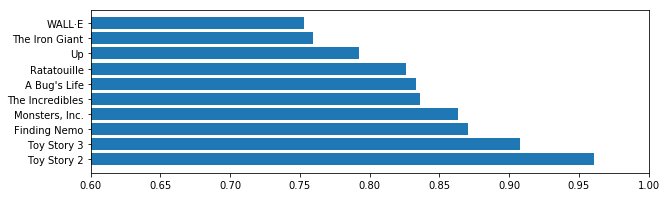

In [ ]:
# XXX
def g(sim):
    FS = (10, 3)
    fig, ax = plt.subplots(figsize=FS)
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    labels = [t[0] for t in sim]
    plt.yticks(y, labels)
    
sim = kv.most_similar('Toy Story')
g(sim)

Wow, these are pretty great! It makes perfect sense that *Toy Story 2* is the most similar movie to *Toy Story*. And most of the rest are animated kids movies with a similar computer-animated style.

So it's learned something about 3-d animated kids flick, but maybe that was just a fluke. Let's look at the closest neighbours for a few more movies from a variety of genres:

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


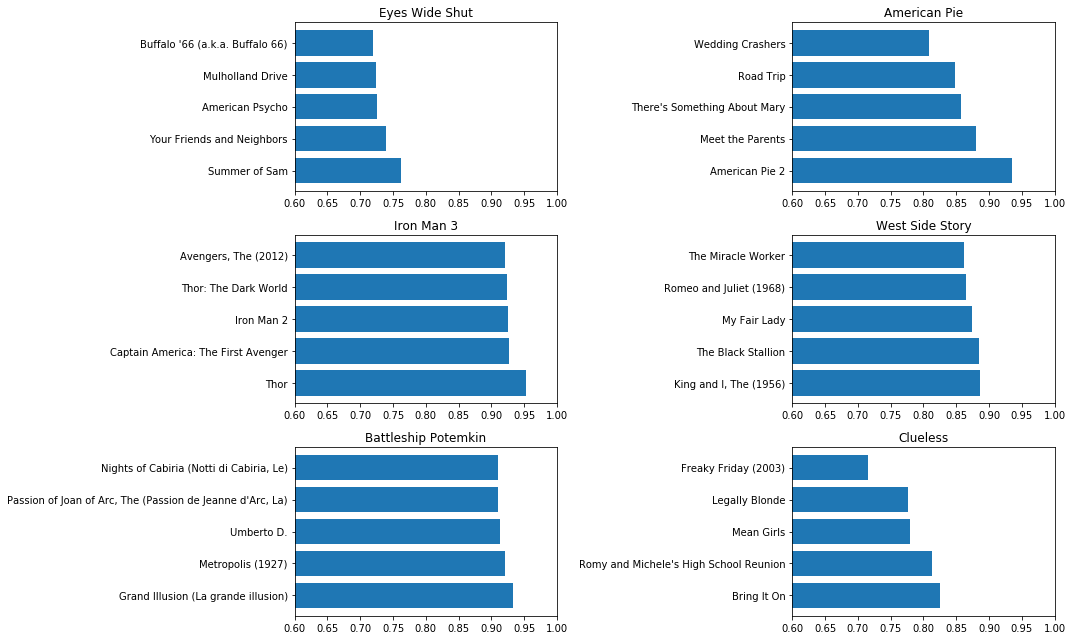

In [ ]:
#$HIDE_INPUT$
movies = ['Eyes Wide Shut', 'American Pie', 'Iron Man 3', 'West Side Story',
          'Battleship Potemkin', 'Clueless'
]

topn = 5
def plot_most_similar(movie, ax):
    # XXX: Reverse top-to-bottom order
    sim = kv.most_similar(movie, topn=topn)
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # TODO: word wrap long titles
    labels = [t[0] for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(movie)    

fig, axes = plt.subplots(3, 2, figsize=(15, 9))

for movie, ax in zip(movies, axes.flatten()):
    plot_most_similar(movie, ax)
    
fig.tight_layout()

Artsy erotic dramas, raunchy sophomoric comedies, old-school musicals, superhero movies... our embeddings manage to nail a wide variety of cinematic niches!

# Semantic vector math

The [`most_similar`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.most_similar) method optionally takes a second argument, `negative`. If we call `kv.most_similar(a, b)`, then instead of finding the vector closest to `a`, it will find the closest vector to `a - b`.

Why would you want to do that? It turns out that doing addition and subtraction of embedding vectors often gives surprisingly meaningful results. For example, how would you fill in the following equation?

    Scream = Psycho + ________

*Scream* and *Psycho* are similar in that they're violent, scary movies somewhere on the border between Horror and Thriller. The biggest difference is that *Scream* has elements of comedy. So I'd say *Scream* is what you'd get if you combined *Psycho* with a comedy.

But we can actually ask Gensim to fill in the blank for us via vector math (after some rearranging):

    ________ = Scream - Psycho

In [ ]:
kv.most_similar(
    positive = ['Scream'],
    negative = ['Psycho (1960)']
)

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Scream 3', 0.706050455570221),
 ('Not Another Teen Movie', 0.6986004114151001),
 ("Charlie's Angels", 0.6872206330299377),
 ('Scream 2', 0.6819695830345154),
 ('Deuce Bigalow: Male Gigolo', 0.6795015335083008),
 ('I Know What You Did Last Summer', 0.6790268421173096),
 ('Urban Legend', 0.6780602335929871),
 ('Final Destination 5', 0.6768518686294556),
 ('Mortal Kombat', 0.672700047492981),
 ('Freddy vs. Jason', 0.6654627323150635)]

If you are familiar with these movies, you'll see that the missing ingredient that takes us from *Psycho* to *Scream* is comedy (and also late-90's-teen-movie-ness).

## Analogy solving

The SAT test which is used to get into American colleges and universities poses analogy questions like:

    shower : deluge :: _____ : stare
    
(Read "shower is to deluge as ___ is to stare")

To solve this, we find the relationship between deluge and shower, and apply it to stare. A shower is a milder form of a deluge. What's a milder form of stare? A good answer here would be "glance", or "look". 

It's kind of astounding that this works, but people have found that these can often be effectively solved by simple vector math on word embeddings. Can we solve movie analogies with our embeddings? Let's try. What about:

    Brave : Cars 2 :: Pocahontas : _____
    
The answer is not clear. One interpretation would be that *Brave* is like *Cars 2*, except that the latter is aimed primarily at boys, and the former might be more appealing to girls, given its female protagonist. So maybe the answer should be, like *Pocahontas*, a mid-90's conventional animation kids movie, but more of a 'boy movie'. *Hercules*? *The Lion King*? 

Let's ask our embeddings what they think.

In terms of vector math, we can frame this as...

    Cars 2 = Brave + X
    _____  = Pocahontas + X
    
Rearranging, we get:

    ____ = Pocahontas + (Cars 2 - Brave)

We can solve this by passing in two movies (*Pocahontas* and *Cars 2*) for the positive argument to `most_similar`, with *Brave* as the negative argument:

In [ ]:
kv.most_similar(
    [k('Pocahontas'), k('Cars 2')],
    negative = [k('Brave')]
)

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('All Dogs Go to Heaven 2', 0.9260742664337158),
 ('Land Before Time III: The Time of the Great Giving', 0.918289303779602),
 ('The Care Bears Movie', 0.8927395343780518),
 ('The Return of Jafar', 0.8905964493751526),
 ("Look Who's Talking Too", 0.8898681402206421),
 ('Free Willy 2: The Adventure Home', 0.8858574032783508),
 ('D-War (Dragon Wars)', 0.8841818571090698),
 ('Dunston Checks In', 0.8801975250244141),
 ('Homeward Bound II: Lost in San Francisco', 0.876905083656311),
 ("Beethoven's 2nd", 0.8767789602279663)]

This weakly fits our prediction: the 4 closest movies are indeed kids animated movies from the 90s. After that, the results are a bit more perplexing.

Is our model wrong, or were we? Another difference we failed to account for between *Cars 2* and *Brave* is that the former is a sequel, and the latter is not. 7/10 of our results are also sequels. This tells us something interesting about our learned embeddings (and, ultimately, about the problem of predicting movie preferences). "Sequelness" is an important property to our model - which suggests that some of the variance in our data is accounted for the fact that some people tend to like sequels more than others.

# Your Turn

**TODO: link**

In [ ]:
# scratch space below - please ignore

kv.most_similar(k('Star Wars: Episode I - The Phantom Menace'))

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Star Wars: Episode II - Attack of the Clones', 0.9800273776054382),
 ('Star Wars: Episode III - Revenge of the Sith', 0.9170121550559998),
 ('The Matrix Revolutions', 0.8769842386245728),
 ('The Matrix Reloaded', 0.8610888719558716),
 ('Star Wars: The Clone Wars', 0.8049086928367615),
 ('Indiana Jones and the Kingdom of the Crystal Skull', 0.7697553634643555),
 ('Star Trek: Nemesis', 0.7504496574401855),
 ('Final Fantasy: The Spirits Within', 0.7422045469284058),
 ('Star Trek: Insurrection', 0.7172819972038269),
 ('Van Helsing', 0.7123873829841614)]

In [ ]:
kv.most_similar(k('Harry Potter and the Goblet of Fire'))

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Harry Potter and the Prisoner of Azkaban', 0.9866541624069214),
 ('Harry Potter and the Order of the Phoenix', 0.9812498688697815),
 ('Harry Potter and the Chamber of Secrets', 0.977340042591095),
 ("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)",
  0.9772845506668091),
 ('Harry Potter and the Half-Blood Prince', 0.9711997509002686),
 ('Harry Potter and the Deathly Hallows: Part 1', 0.9447852373123169),
 ('Harry Potter and the Deathly Hallows: Part 2', 0.9428168535232544),
 ('The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
  0.7831770181655884),
 ('The Hunger Games: Catching Fire', 0.7747126221656799),
 ('X2: X-Men United', 0.70066899061203)]

In [ ]:
kv.most_similar(k('Harry Potter and the Goblet of Fire'))

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Harry Potter and the Prisoner of Azkaban', 0.9866541624069214),
 ('Harry Potter and the Order of the Phoenix', 0.9812498688697815),
 ('Harry Potter and the Chamber of Secrets', 0.977340042591095),
 ("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)",
  0.9772845506668091),
 ('Harry Potter and the Half-Blood Prince', 0.9711997509002686),
 ('Harry Potter and the Deathly Hallows: Part 1', 0.9447852373123169),
 ('Harry Potter and the Deathly Hallows: Part 2', 0.9428168535232544),
 ('The Chronicles of Narnia: The Lion, the Witch and the Wardrobe',
  0.7831770181655884),
 ('The Hunger Games: Catching Fire', 0.7747126221656799),
 ('X2: X-Men United', 0.70066899061203)]

In [ ]:
kv.most_similar(k('Harry Potter and the Deathly Hallows: Part 2'))

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Harry Potter and the Deathly Hallows: Part 1', 0.9689458608627319),
 ('Harry Potter and the Half-Blood Prince', 0.9586865901947021),
 ('Harry Potter and the Prisoner of Azkaban', 0.9516866207122803),
 ('Harry Potter and the Order of the Phoenix', 0.9504743814468384),
 ('Harry Potter and the Goblet of Fire', 0.9428168535232544),
 ("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)",
  0.8973463177680969),
 ('Harry Potter and the Chamber of Secrets', 0.8862634897232056),
 ('The Hunger Games: Catching Fire', 0.8423014879226685),
 ('How to Train Your Dragon 2', 0.7677023410797119),
 ('The Hunger Games', 0.7418676614761353)]

In [ ]:
kv.distance(
    k('Harry Potter and the Goblet of Fire'),
    k('Harry Potter and the Deathly Hallows: Part 2'),
)

/home/colinmorris/.local/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.05718313750864279

In [ ]:
print(
    k('Harry Potter and the Goblet of Fire'),
    k('Harry Potter and the Deathly Hallows: Part 2'),
    sep='\n',
)

Harry Potter and the Goblet of Fire
Harry Potter and the Deathly Hallows: Part 2


In [ ]:
v = kv.vocab['Harry Potter and the Deathly Hallows: Part 2 (2011)']
print(v.count, v.index)

KeyError: 'Harry Potter and the Deathly Hallows: Part 2 (2011)'

In [ ]:
df = mainstream_movies
key_counts = df['key'].value_counts()
key_counts[key_counts > 1]

In [ ]:

df[df.title.str.contains('Harry Potter')]